# $\mathcal{l}_2$ penalty method algorithm

In [23]:
# References

# norms_sqrd(S,X) - max(norms_sqrd(S,X))

# beta = max(norms_sqrd)

# V = s_x_list_norms(S,X)**2 - max(s_x_list_norms(S,X)**2)
# max(0,V[5])

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import sklearn.datasets
from math import pi, sin, cos

In [3]:
#no. of sensors
FIELDSIZE = 100
#sensor location range
SCALE = 1000
#lambda for poisson distr.
# LAM = 50

In [3]:
from math import pi, cos, sin
#generate random points on the circumference of a circle
def point(h, k, r):
    theta = random.random() * 2 * pi
    return (h + cos(theta) * r, k + sin(theta) * r)

In [4]:
centers = [point(50,50,50) for _ in range(8)]

In [4]:
#generate a set of sensors, X generated randomly and a random starting point, S
S = np.array([random.random()*SCALE, random.random()*SCALE])

#X uniform
X = np.array([ [ random.random()*SCALE, random.random()*SCALE ] for i in range(FIELDSIZE) ])

#X Poisson
#X = np.random.poisson(LAM, (FIELDSIZE, 2))

# generate random points on the circumference of a circle
# X = np.array([point(FIELDSIZE,FIELDSIZE,FIELDSIZE) for _ in range(FIELDSIZE)])

#X blobs
#X = sklearn.datasets.make_blobs(n_samples=FIELDSIZE, centers = centers, cluster_std = 3)
#X = X[0]

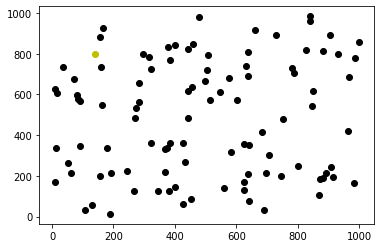

In [5]:
x0 = [X[i][0] for i in range(FIELDSIZE)]
x1 = [X[i][1] for i in range(FIELDSIZE)]
plt.scatter(x0,x1, c = 'k')
plt.scatter(S[0], S[1], c = 'y')
plt.show()

In [6]:
def s_x_list(s,x):
    arr1 = []
    for i in range(FIELDSIZE):
        t1 = s - x[i]
        arr1.append(t1)
    return np.array(arr1)

In [7]:
def norms_sqrd(s,x):
    arr1 = []
    for i in range(FIELDSIZE):
        t1 = s - x[i]
        t2 = np.array(t1)
        t3 = np.linalg.norm(t2)**2
        arr1.append(t3)
    return np.array(arr1)

In [8]:
def gradient_function(s,x,k,b):
    N = norms_sqrd(s,x)
    s_minus_x = s_x_list(s,x)
    g_max = []
    if  max(norms_sqrd(s,x)) < b: #update beta if its closer
        b = max(norms_sqrd(s,x))
    for i in range(FIELDSIZE):
        g = N[i] - b
        g_plus = max(0,g)
        g_max.append(s_minus_x[i]*g_plus)
    grad = 2*sum(s_minus_x) + 2*(k**2)*sum(g_max)
    return grad

In [14]:
# Adaptive GD, Steepest Descent
def GD(s,x,k,b, step): return s - step*gradient_function(s,x,k,b)
def Descent(s,x, EPSILON):
    
    t_start = time.time()
    s0 = s
#     print('s', s0)
    k=1
    
    beta = max(norms_sqrd(s0,x))
#     print("beta", beta)
    s_list_adaptive = [s0]
    grad_norm = np.linalg.norm(gradient_function(s0,x,k,beta))
    norm_list_adaptive = [grad_norm]
    time_list_adaptive =[time.time() - t_start]
    lam = 1 / np.max( np.linalg.svd( x @ x.T ) [1] ) # approximating Lipschitz constant with SVD (MATLAB ok)
    theta = float(random.getrandbits(128)) # this should essentially be infinity
#     print('lambda', lam)
#     lam_list_adaptive = [round(lam, 5)]

    s1 = GD(s0,x,k,beta,lam)
#     print('s', s1)
    s_list_adaptive.append(s1)
    grad_norm = np.linalg.norm(gradient_function(s1,x,k,beta))
    norm_list_adaptive.append(grad_norm)
    time_list_adaptive.append(time.time() - t_start)
    k=2
    
    while grad_norm > EPSILON:
#         t1_start = time.time()
#         print("point distance", np.linalg.norm(s1 - s0))
#         if max(norms_sqrd(s1,x)) < beta:
#             beta = max(norms_sqrd(s1,x))
#         print("beta", beta)
        old_lam = lam
        min1 = np.sqrt(1 + theta)*old_lam
#         print("min1", min1)
        min2 = np.linalg.norm(s1-s0)/(2*np.linalg.norm(gradient_function(s1, x, k, beta) - gradient_function(s0, x, k, beta) ))
#         print("min2", min2)
        lam = np.min([min1, min2])
#         print('lambda', lam)
        theta = lam/old_lam
        s0 = s1
        s1 = GD(s0, x, k, beta, lam )
#         print('s', s1)
#         s_list.append(s1)
        s_list_adaptive.append(s1)
        grad_norm = np.linalg.norm(gradient_function(s1,x,k,beta))
        norm_list_adaptive.append(grad_norm)
        time_list_adaptive.append(time.time() - t_start)
    
        #add lam to lam_list
#         lam_list.append(round(lam, 5))
        
        #add norm of grad to norm_list
#         norm_list.append(round(np.linalg.norm(gradient_function(s1,x,k,beta)), 4))
        
        
        k+=1
#         t1_end = time.time()
        
        #add calctime of iteration to time_list
#         iter_time = t1_end - t1_start
#         time_list.append(round(iter_time, 5))
        
#     t_end = time.time()
    #calculate total time of program
#     duration = [t_end-t_start]
    
    return np.array([s_list_adaptive, norm_list_adaptive, time_list_adaptive])

In [15]:
# import pandas as pd

In [16]:
TEST = Descent(S,X,1e-6)

<ipython-input-14-ffbdea4441a6>:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([s_list_adaptive, norm_list_adaptive, time_list_adaptive])


In [17]:
TEST

array([[array([140.68212411, 800.68294858]),
        array([140.68336907, 800.68182494]),
        array([316.16550268, 642.30123491]),
        array([403.90656949, 563.11093989]),
        array([447.77710289, 523.51579238]),
        array([469.7123696 , 503.71821863]),
        array([480.68000295, 493.81943175]),
        array([486.16381962, 488.87003832]),
        array([488.90572796, 486.3953416 ]),
        array([490.27668213, 485.15799324]),
        array([490.96215921, 484.53931906]),
        array([491.30489775, 484.22998197]),
        array([491.47626703, 484.07531342]),
        array([491.56195166, 483.99797915]),
        array([491.60479398, 483.95931201]),
        array([491.62621514, 483.93997844]),
        array([491.63692572, 483.93031166]),
        array([491.64228101, 483.92547827]),
        array([491.64495865, 483.92306157]),
        array([491.64629747, 483.92185322]),
        array([491.64696689, 483.92124905]),
        array([491.64730159, 483.92094696]),
        ar

In [28]:
# #test0: x-coords of each step
# #test1: y-coords of each step
# test0 = [TEST[0][i][0] for i in range(len(TEST[0]))]
# test1 = [TEST[0][i][1] for i in range(len(TEST[0]))]

# coords = list(zip(test0, test1))

# testPD = pd.DataFrame({'coords': coords, 'norm':TEST[1], 'lambda':TEST[2], 'iter_time':TEST[3]})

# testPD.head(10)

# testPD.to_csv('tables/circle.txt',
#               sep = '&'
# )

In [29]:
#x0 = [X[i][0] for i in range(FIELDSIZE)]
#x1 = [X[i][1] for i in range(FIELDSIZE)]
#plt.scatter(x0,x1, c = 'k')
#plt.scatter(test0[0], test1[0], c = 'y')
#plt.plot(test0, test1, c = 'y')
#plt.scatter(test0[-1], test1[-1], c = 'y')
#plt.show()

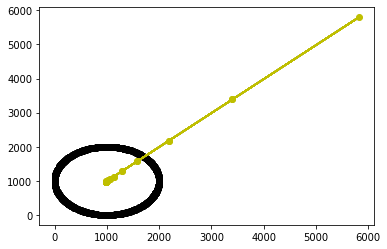

In [32]:
# #Plot scatter plot of sensors
# x0 = [X[i][0] for i in range(FIELDSIZE)]
# x1 = [X[i][1] for i in range(FIELDSIZE)]

# #Plot each step k
# plt.scatter(x0,x1, c = 'k')
# for i in range(len(test0)-1):
    

#     plt.scatter(test0[i], test1[i], c = 'y')
#     plt.plot(test0, test1, c = 'y')
#     plt.scatter(test0[i+1], test1[i+1], c = 'y')
#     i+=1
# plt.savefig('circl2_2.png')
# plt.show()


In [49]:
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator

In [20]:
def ren(x): return range(len(x))

In [28]:
TEST[1]

array([94554.77730765051, 94554.44189676706, 47277.22094913762,
       23638.610474568824, 11819.305237284385, 5909.652618642202,
       2954.826309321097, 1477.4131546605522, 738.7065773302763,
       369.35328866513225, 184.6766443325624, 92.33832216628527,
       46.16916108314024, 23.08458054156616, 11.542290270782628,
       5.771145135390861, 2.8855725676959905, 1.442786283845601,
       0.7213931419184745, 0.36069657096422697, 0.18034828548154308,
       0.09017414273999268, 0.04508707136979572, 0.022543535680571852,
       0.011271767842006036, 0.0056358839226190605, 0.0028179419553285034,
       0.0014089709740134095, 0.0007044854892957659,
       0.0003522427455122195, 0.00017612137721908545,
       8.806068933942873e-05, 4.403034480738731e-05,
       2.2015167773000328e-05, 1.1007581721884655e-05,
       5.503794502485593e-06, 2.7518926205494607e-06,
       1.375943840975614e-06, 6.879748003225432e-07], dtype=object)

In [29]:
s_x_axis_adaptive = [TEST[0][i][0] for i in ren(TEST[0])]
s_y_axis_adaptive = [TEST[0][i][1] for i in ren(TEST[0])]
norm_adaptive = TEST[1]
time_adaptive = TEST[2]

Baz_bor algor

In [31]:
I = np.array([[1,0,0],[0,1,0],[0,0,1]])

In [33]:
I@np.array([1,2,3])

array([1, 2, 3])

In [37]:
np.array([[5,8,6],[9,3,2],[4,2,3]])@np.array([[5],[8],[9]])

array([[143],
       [ 87],
       [ 63]])

In [46]:
# Barzalai Borwein, BFGS
def GD(s,direction, step): return s + step*direction
def Descent(s,x, EPSILON):
    H0 = np.array([[1,0],[0,1]])
    t_start = time.time()
    s0 = s
    k=1
    beta = max(norms_sqrd(s0,x))
    s_list_baz = [s0]
    grad_norm = np.linalg.norm(gradient_function(s0,x,k,beta))
    norm_list_baz = [grad_norm]
    time_list_baz =[time.time() - t_start]
    lam = 1 / np.max( np.linalg.svd( x @ x.T ) [1] )
    d = -H0@gradient_function(s0,x,k,beta).T
    s1 = GD(s0,d,lam)
    s_list_baz.append(s1)
    grad_norm = np.linalg.norm(gradient_function(s1,x,k,beta))
    norm_list_baz.append(grad_norm)
    time_list_baz.append(time.time() - t_start)
    k=2
    
    while grad_norm > EPSILON:
        sigma = s1 - s0
        g = gradient_function(s1,x,k,beta) - gradient_function(s0,x,k,beta)
        r = (H0@g.T)/np.dot(sigma,g)
        H1 = H0 + ((1 + np.dot(r,g))/np.dot(sigma,g))*sigma.T@sigma - ( sigma.T@r - r.T@sigma )
        d = - H1@gradient_function(s1,x,k,beta).T
        nom = np.dot(s1 - s0, gradient_function(s1,x,k,beta) - gradient_function(s0,x,k,beta))
        denom = np.linalg.norm(gradient_function(s1,x,k,beta) - gradient_function(s0,x,k,beta))**2
        lam = nom/denom
        s0 = s1
        s1 = GD(s0, d , lam )
        s_list_baz.append(s1)
        grad_norm = np.linalg.norm(gradient_function(s1,x,k,beta))
        norm_list_baz.append(grad_norm)
        time_list_baz.append(time.time() - t_start)
        H0 = H1
        k+=1
    return np.array([s_list_baz, norm_list_baz, time_list_baz])

In [47]:
TEST2 = Descent(S,X,1e-6)

<ipython-input-46-d09f2c7a6e0b>:25: RuntimeWarning: invalid value encountered in true_divide
  r = (H0@g.T)/np.dot(sigma,g)
<ipython-input-46-d09f2c7a6e0b>:30: RuntimeWarning: invalid value encountered in double_scalars
  lam = nom/denom
<ipython-input-46-d09f2c7a6e0b>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([s_list_baz, norm_list_baz, time_list_baz])


In [49]:
TEST2

array([[array([140.68212411, 800.68294858]),
        array([140.68336907, 800.68182494]),
        array([526.02173889, 518.29474748]),
        array([350.25509733, 342.5281059 ]),
        array([2520.635469  , 2512.90847758]),
        array([-97426.39890545, -97432.51409072]),
        array([13710065.97244726, 13710058.17712092]),
        array([-5.70881566e+09, -5.70881567e+09]),
        array([7.10940955e+12, 7.10940955e+12]),
        array([-2.65326979e+16, -2.65326979e+16]),
        array([2.96958564e+20, 2.96958564e+20]),
        array([-9.96964895e+24, -9.96964895e+24]),
        array([1.00407901e+30, 1.00407901e+30]),
        array([-3.03369154e+35, -3.03369154e+35]),
        array([2.74975682e+41, 2.74975682e+41]),
        array([-7.4771789e+47, -7.4771789e+47]),
        array([6.09961323e+54, 6.09961323e+54]),
        array([6.09961323e+54, 6.09961323e+54]), array([nan, nan])],
       [94554.77730765051, 94554.44189676706, 9722.464417370296,
        39991.84924647444, 68415738

In [51]:
s_x_axis_baz = [TEST2[0][i][0] for i in range(len(TEST2[0])-1)]
s_y_axis_baz = [TEST[0][i][1] for i in range(len(TEST2[0])-1)]
norm_baz = TEST2[1][0:-1]
time_baz = TEST2[2][0:-1]

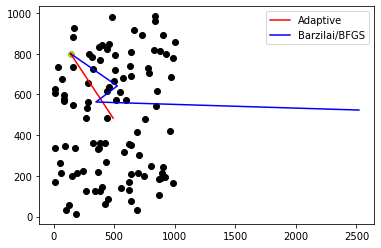

In [66]:
x0 = [X[i][0] for i in range(FIELDSIZE)]
x1 = [X[i][1] for i in range(FIELDSIZE)]
plt.scatter(x0,x1, c = 'k')
plt.scatter(S[0], S[1], c = 'y')
plt.plot(s_x_axis_adaptive, s_y_axis_adaptive, 'r', label = 'Adaptive')
plt.plot(s_x_axis_baz[0:5], s_y_axis_baz[0:5], 'b', label = 'Barzilai/BFGS')
plt.legend(loc='best')
plt.savefig('Adap_vs_Baz_steps.png')
plt.show()

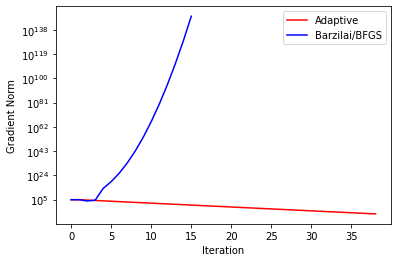

In [68]:
plt.plot(ren(norm_adaptive), norm_adaptive, 'r', label = 'Adaptive')
plt.plot(ren(norm_baz), norm_baz, 'b', label = 'Barzilai/BFGS')
plt.legend(loc='best')
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.yscale('log')
plt.savefig('Adap_vs_Baz_norms.png')
plt.show()

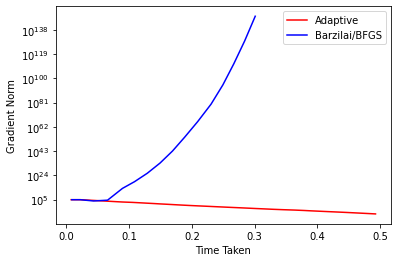

In [69]:
plt.plot(time_adaptive, norm_adaptive, 'r', label = 'Adaptive')
plt.plot(time_baz, norm_baz, 'b', label = 'Barzilai/BFGS')
plt.legend(loc='best')
plt.xlabel('Time Taken')
plt.ylabel('Gradient Norm')
plt.yscale('log')
plt.savefig('Adap_vs_Baz_norms_vs_time.png')
plt.show()

In [73]:
# Adaptive GD, Steepest Descent
def GD(s,x,k,b, step): return s - step*gradient_function(s,x,k,b)
def Descent(s,x, EPSILON):
    
    t_start = time.time()
    s0 = s
#     print('s', s0)
    k=1
    
    beta = max(norms_sqrd(s0,x))
#     print("beta", beta)
    s_list_baz = [s0]
    grad_norm = np.linalg.norm(gradient_function(s0,x,k,beta))
    norm_list_baz = [grad_norm]
    time_list_baz =[time.time() - t_start]
    lam = 1 / np.max( np.linalg.svd( x @ x.T ) [1] ) # approximating Lipschitz constant with SVD (MATLAB ok)
    theta = float(random.getrandbits(128)) # this should essentially be infinity
#     print('lambda', lam)
#     lam_list_adaptive = [round(lam, 5)]

    s1 = GD(s0,x,k,beta,lam)
#     print('s', s1)
    s_list_baz.append(s1)
    grad_norm = np.linalg.norm(gradient_function(s1,x,k,beta))
    norm_list_baz.append(grad_norm)
    time_list_baz.append(time.time() - t_start)
    k=2
    
    while grad_norm > EPSILON:
#         t1_start = time.time()
#         print("point distance", np.linalg.norm(s1 - s0))
#         if max(norms_sqrd(s1,x)) < beta:
#             beta = max(norms_sqrd(s1,x))
#         print("beta", beta)
        nom = np.dot(s1 - s0, gradient_function(s1,x,k,beta) - gradient_function(s0,x,k,beta))
        denom = np.linalg.norm(gradient_function(s1,x,k,beta) - gradient_function(s0,x,k,beta))**2
        lam = nom/denom
        s0 = s1
        s1 = GD(s0, x, k, beta, lam )
#         print('s', s1)
#         s_list.append(s1)
        s_list_baz.append(s1)
        grad_norm = np.linalg.norm(gradient_function(s1,x,k,beta))
        norm_list_baz.append(grad_norm)
        time_list_baz.append(time.time() - t_start)
    
        #add lam to lam_list
#         lam_list.append(round(lam, 5))
        
        #add norm of grad to norm_list
#         norm_list.append(round(np.linalg.norm(gradient_function(s1,x,k,beta)), 4))
        
        
        k+=1
#         t1_end = time.time()
        
        #add calctime of iteration to time_list
#         iter_time = t1_end - t1_start
#         time_list.append(round(iter_time, 5))
        
#     t_end = time.time()
    #calculate total time of program
#     duration = [t_end-t_start]
    
    return np.array([s_list_baz, norm_list_baz, time_list_baz])

In [74]:
TEST3 = Descent(S,X,1e-6)

<ipython-input-73-ef0975c6dd66>:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([s_list_baz, norm_list_baz, time_list_baz])


In [75]:
TEST3

array([[array([140.68212411, 800.68294858]),
        array([140.68336907, 800.68182494]),
        array([491.64763629, 483.92064488]),
        array([491.6476363 , 483.92064488])],
       [94554.77730765051, 94554.44189676706, 1.5081776391645708e-06,
        8.601970165740088e-12],
       [0.0069582462310791016, 0.01934361457824707, 0.03819131851196289,
        0.0555880069732666]], dtype=object)

In [89]:
s_x_axis_baz = [round(TEST3[0][i][0],4) for i in ren(TEST3[0])]
s_y_axis_baz = [round(TEST3[0][i][1],4) for i in ren(TEST3[0])]
norm_baz = TEST3[1]
time_baz = TEST3[2]

In [90]:
time_baz

array([0.0069582462310791016, 0.01934361457824707, 0.03819131851196289,
       0.0555880069732666], dtype=object)

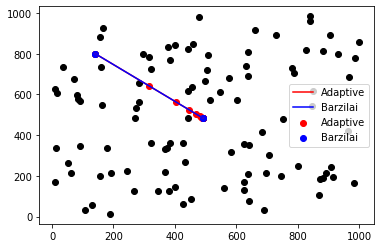

In [85]:
x0 = [X[i][0] for i in range(FIELDSIZE)]
x1 = [X[i][1] for i in range(FIELDSIZE)]
plt.scatter(x0,x1, c = 'k')
plt.scatter(S[0], S[1], c = 'y')
plt.scatter(s_x_axis_adaptive, s_y_axis_adaptive, c ='r', label = 'Adaptive')
plt.scatter(s_x_axis_baz, s_y_axis_baz, c ='b', label = 'Barzilai')
plt.plot(s_x_axis_adaptive, s_y_axis_adaptive, c ='r', label = 'Adaptive')
plt.plot(s_x_axis_baz, s_y_axis_baz, c ='b', label = 'Barzilai')
plt.legend(loc='best')
plt.savefig('Adap_vs_Pure_Baz_steps.png')
plt.show()

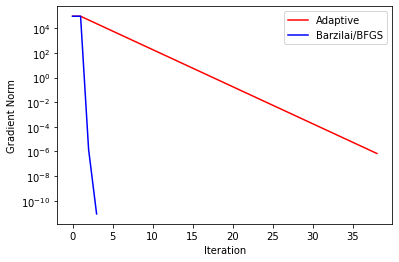

In [86]:
plt.plot(ren(norm_adaptive), norm_adaptive, 'r', label = 'Adaptive')
plt.plot(ren(norm_baz), norm_baz, 'b', label = 'Barzilai/BFGS')
plt.legend(loc='best')
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.yscale('log')
plt.savefig('Adap_vs_Pure_Baz_norms.png')
plt.show()

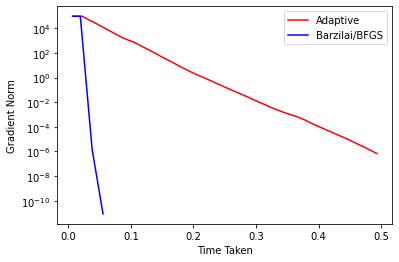

In [91]:
plt.plot(time_adaptive, norm_adaptive, 'r', label = 'Adaptive')
plt.plot(time_baz, norm_baz, 'b', label = 'Barzilai/BFGS')
plt.legend(loc='best')
plt.xlabel('Time Taken')
plt.ylabel('Gradient Norm')
plt.yscale('log')
plt.savefig('Adap_vs_Pute_Baz_norms_vs_time.png')
plt.show()